# Dam Command Area Map Figures

This notebook visualizes dam command areas, irrigated area rasters, and Center Pivot Irrigation Systems (CPIS) for selected dams in Sub-Saharan Africa. It demonstrates spatial alignment and overlay of vector and raster data, using utility functions for robust and reproducible data loading and processing.

## 1. Import Libraries and Utilities
Import required libraries and utility functions for spatial data processing and visualization.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
from shapely.geometry import box, mapping
import rasterio
from rasterio.mask import mask
import matplotlib.colors as mcolors
import os
import sys

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_and_reproject, optimized_clip

# Load configuration
config = load_config()

## 2. Load Configuration and Data
Use utility functions to load configuration and spatial datasets, ensuring consistent CRS and robust file resolution.

In [3]:
# Load configuration
config = load_config()

# Load data using utility functions
cpis = load_and_reproject(resolve_path(config['SSA_Combined_CPIS_All_shp_path']), target_crs="EPSG:3857")
dams = load_and_reproject(resolve_path(config['AridAfrica_Barriers_shp_path']), target_crs="EPSG:3857")
ca = load_and_reproject(resolve_path(config['No_Crop_Vectorized_Command_Area_shp_path']), target_crs="EPSG:3857")
irrig_raster_path = resolve_path(config['Africa_AEI_2000_asc_path'])

## 3. Select Example Dam and Command Area
Focus on a specific dam (GDW_ID 407) and its command area for demonstration.

In [4]:
# Focus on GDW_ID 407
example_dam = dams[dams["GDW_ID"] == 407]
ca_407 = ca[ca["GDW_ID"] == 407]

## 4. Clip Data to Area of Interest
Buffer the command area, clip CPIS polygons, and prepare the raster for visualization.

In [5]:
# Crop raster to extent
buffer_dist = 100000  # 100km
bbox = ca_407.geometry.buffer(buffer_dist).total_bounds
bbox_geom = box(*bbox)
bbox_gdf = gpd.GeoDataFrame({"geometry": [bbox_geom]}, crs=ca_407.crs)
cpis_clip = optimized_clip(cpis, bbox_gdf)

## 5. Load and Mask Raster Data
Clip the irrigated area raster to the buffered extent and mask out non-irrigated/nodata pixels.

In [6]:
with rasterio.open(irrig_raster_path) as src:
    # If CRS is missing, assign it manually
    if src.crs is None:
        from rasterio.crs import CRS
        raster_crs = CRS.from_epsg(4326)
    else:
        raster_crs = src.crs
    print("Original raster CRS:", raster_crs)
    # Reproject bbox_gdf to raster CRS
    bbox_gdf_raster_crs = bbox_gdf.to_crs(raster_crs)
    bbox_geom_raster_crs = [mapping(bbox_gdf_raster_crs.geometry.iloc[0])]
    # Get the raster data within our bbox
    out_image, out_transform = mask(src, bbox_geom_raster_crs, crop=True)
    # Get the bounds of the cropped raster in its original CRS
    raster_bounds = rasterio.transform.array_bounds(
        out_image.shape[1], out_image.shape[2], out_transform
    )
    # Create a GeoDataFrame with the raster bounds
    raster_bbox = box(*raster_bounds)
    raster_gdf = gpd.GeoDataFrame(geometry=[raster_bbox], crs=raster_crs)
    # Reproject the raster bounds to the same CRS as our vector data (EPSG:3857)
    raster_gdf_3857 = raster_gdf.to_crs(ca_407.crs)
    # Get the bounds in EPSG:3857 for plotting
    reprojected_bounds = raster_gdf_3857.total_bounds
    # These are the bounds we'll use for imshow
    extent = [
        reprojected_bounds[0],  # left
        reprojected_bounds[2],  # right
        reprojected_bounds[1],  # bottom
        reprojected_bounds[3],  # top
    ]
    # Store the nodata value
    nodata = src.nodata
    print("Raster bounds in original CRS:", raster_bounds)
    print("Reprojected extent for imshow:", extent)
    print("Nodata value:", nodata)
# Mask out non-irrigated and nodata pixels
masked = np.ma.masked_where((out_image[0] <= 0) | (out_image[0] == nodata), out_image[0])

Original raster CRS: EPSG:4326
Raster bounds in original CRS: (24.083333333333314, -29.0, 26.583333333333314, -26.75)
Reprojected extent for imshow: [2680944.4032713366, 2959243.1302545206, -3375646.034919311, -3092272.122885536]
Nodata value: -9.0


## 6. Visual Checks and Debugging
Print statistics and plot intermediate results to verify correct alignment and masking.

out_image min: -9.0
out_image max: 6781.756
out_image shape: (1, 27, 30)
masked min: 0.069929
masked max: 6781.756
masked count (non-masked): 242
masked mask sum (masked pixels): 568


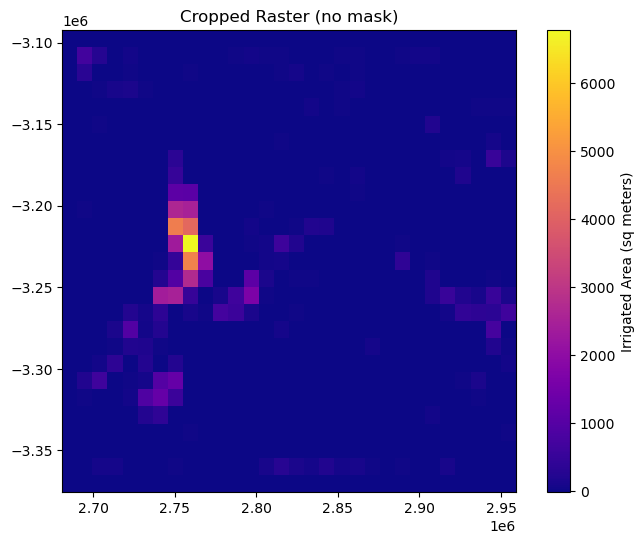

In [7]:
# Print raster and mask stats
print("out_image min:", out_image.min())
print("out_image max:", out_image.max())
print("out_image shape:", out_image.shape)
print("masked min:", masked.min())
print("masked max:", masked.max())
print("masked count (non-masked):", masked.count())
print("masked mask sum (masked pixels):", masked.mask.sum())

# Plot the cropped raster with the correct extent
plt.figure(figsize=(8, 6))
plt.imshow(out_image[0], cmap="plasma", extent=extent, origin='upper')
plt.colorbar(label="Irrigated Area (sq meters)")
plt.title("Cropped Raster (no mask)")
plt.show()

## 7. Overlay Vector and Raster Data
Plot the command area, dam, CPIS, and raster overlay on a basemap for final visualization.

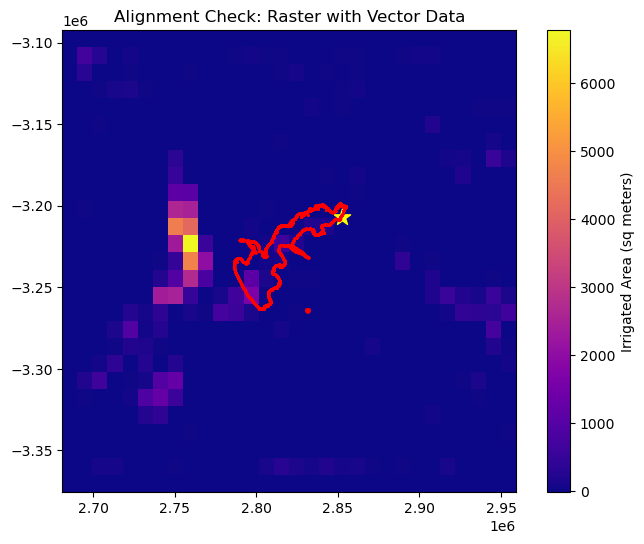

/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


Vector data (ca_407) bounds: [ 2786340.         -3265081.99134833  2855370.         -3198299.70213388]
Vector data (bbox_gdf) bounds: [ 2686340.         -3365081.99134833  2955370.         -3098299.70213388]
Raster extent: [2680944.4032713366, 2959243.1302545206, -3375646.034919311, -3092272.122885536]


/tmp/ipykernel_3000237/3251915304.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


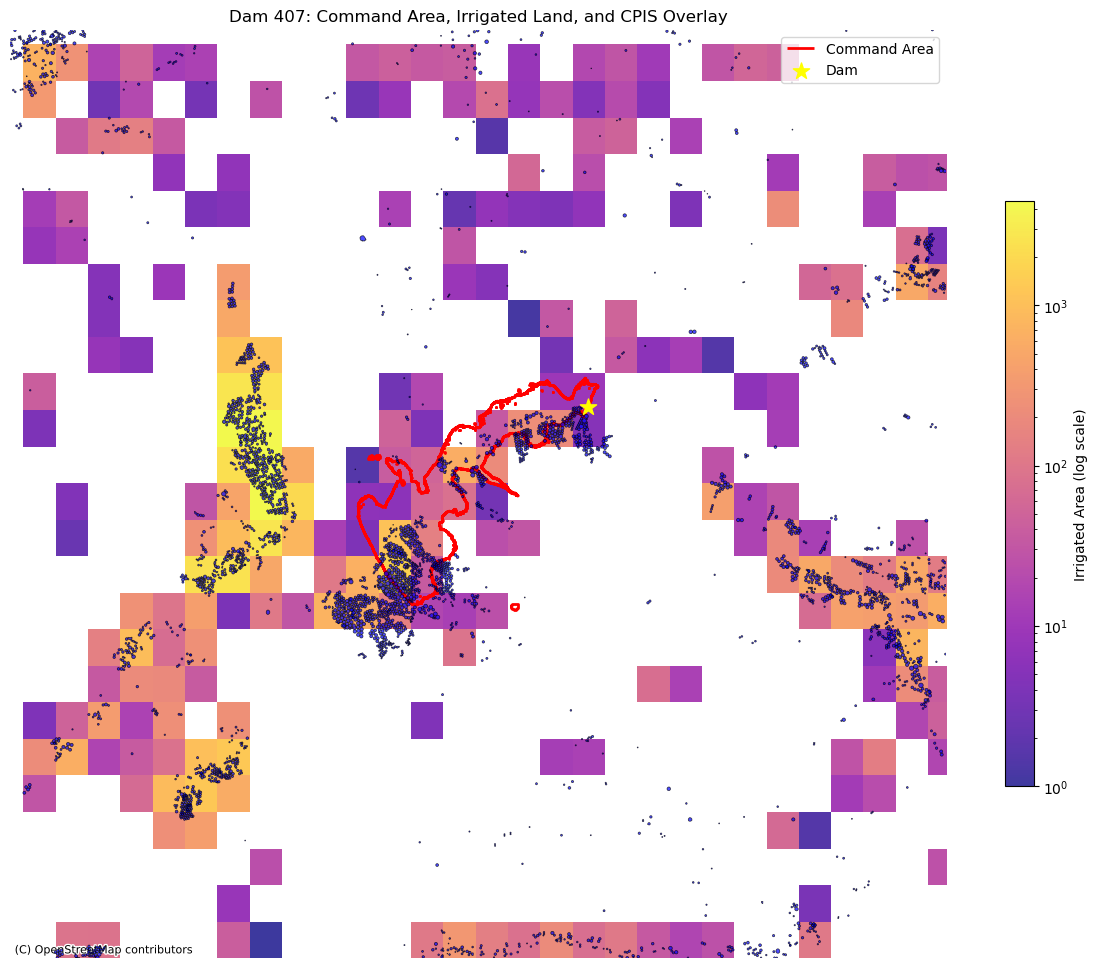

In [8]:
# Plot the vector data with the raster to check alignment
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(out_image[0], cmap="plasma", extent=extent, origin='upper')
ca_407.boundary.plot(ax=ax, color='red', linewidth=2)
example_dam.plot(ax=ax, color='yellow', marker='*', markersize=150)
plt.title("Alignment Check: Raster with Vector Data")
plt.colorbar(label="Irrigated Area (sq meters)")
plt.show()

# Final overlay plot
fig, ax = plt.subplots(figsize=(12, 12))
cx.add_basemap(ax, crs=ca_407.crs, source=cx.providers.OpenStreetMap.Mapnik)
print("Vector data (ca_407) bounds:", ca_407.total_bounds)
print("Vector data (bbox_gdf) bounds:", bbox_gdf.total_bounds)
print("Raster extent:", extent)
img = ax.imshow(
    masked,
    cmap="plasma",
    alpha=0.8,
    extent=extent,
    origin='upper',
    norm=mcolors.LogNorm(vmin=max(1, masked.min()), vmax=np.percentile(masked.compressed(), 99)),
    zorder=2
)
ca_407.boundary.plot(ax=ax, color='red', linewidth=2, label="Command Area", zorder=3)
cpis_clip.plot(ax=ax, facecolor='blue', edgecolor='black', linewidth=0.5, alpha=0.7, label="CPIS", zorder=4)
example_dam.plot(ax=ax, color='yellow', marker='*', markersize=150, label="Dam", zorder=5)
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
cbar = plt.colorbar(img, ax=ax, shrink=0.5, label="Irrigated Area (log scale)")
ax.set_title("Dam 407: Command Area, Irrigated Land, and CPIS Overlay")
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Alignment Verification
Create a simple plot to verify the alignment of vector and raster data extents.

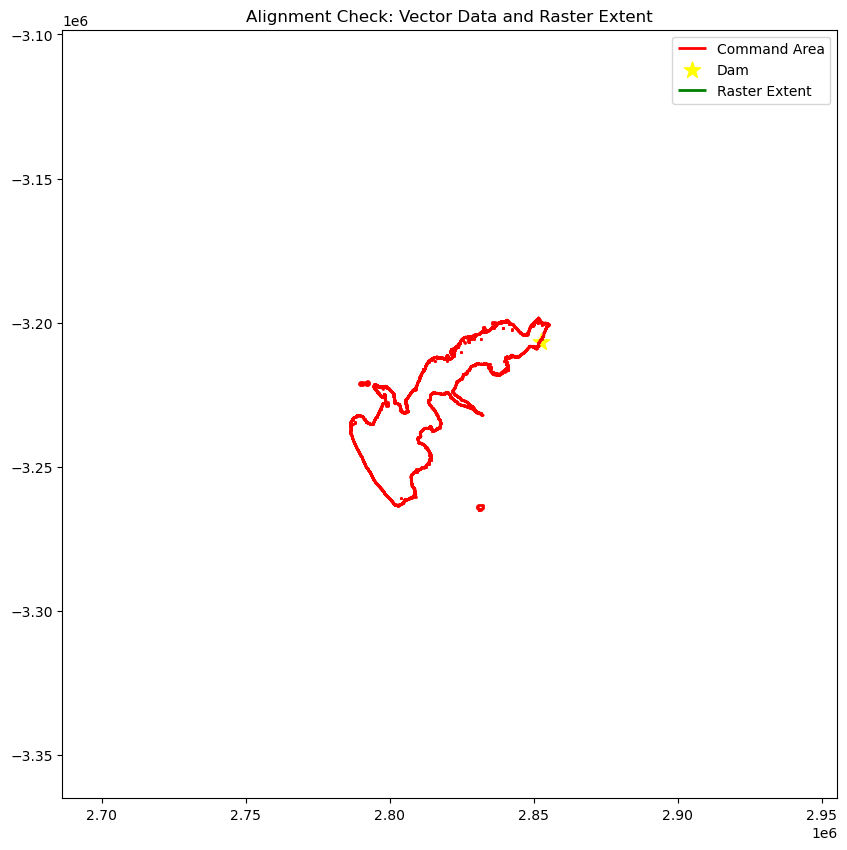

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ca_407.boundary.plot(ax=ax, color='red', linewidth=2, label="Command Area")
example_dam.plot(ax=ax, color='yellow', marker='*', markersize=150, label="Dam")
raster_gdf_3857.boundary.plot(ax=ax, color='green', linewidth=2, label="Raster Extent")
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax.set_title("Alignment Check: Vector Data and Raster Extent")
ax.legend()
plt.show()